In [1]:
!pip install boto3

In [2]:
!pip install astropy

In [3]:
!pip install sfdmap

In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'git')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')
s3_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V1')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

In [5]:
# loading the table
final_table_csv_path = os.path.join(endpoint_url,bucket_name,s3_final_table_csv_path)
gs = pd.read_csv(final_table_csv_path, header = 0, dtype = {
    'specobjid' : str,
    'z' : float,
    'z_noqso' : float,
    'snMedian' : float,
    'run2d' : str,
    'ra' : float,
    'dec' : float,
    'plate' : int,
    'mjd' : int,
    'fiberid' : int,
    'waveMin' : float,
    'waveMax' : float
    })
print('Total galaxies in DR16: %d' % len(gs))

Total galaxies in DR16: 3234563


In [6]:
cnt = len(gs)
total_filtered = 0

In [7]:
# parameters
snr_th = 0.6
z_th = 0.03

In [8]:
# Remove galaxies with low redshift
gs = gs[gs.z > z_th]
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print('Total galaxies filtered with low z values: %d' % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered with low z values: 94412


In [9]:
# Remove galaxies with low SNR
gs = gs[gs.snMedian > snr_th]
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print('Total galaxies filtered with low snr values: %d' % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered with low snr values: 172465


In [10]:
# move to rest frame and calculate span
gs['waveMin_rest'] = np.divide(gs.waveMin,1+gs.z)
gs['waveMax_rest'] = np.divide(gs.waveMax,1+gs.z)
gs['wave_span'] = gs['waveMax_rest']-gs['waveMin_rest']

In [11]:
# using the wavelength grid like before
wl_grid = np.linspace(3825.0,7725.0,7800)
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'wl_grid.npy'))

# filtering wavelengths
gs = gs[gs.waveMin_rest<=min(wl_grid)]
gs = gs[gs.waveMax_rest>=max(wl_grid)]
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print('Total galaxies filtered for wavelength support: %d' % filtered)
cnt = len(gs)
total_filtered += filtered

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V1/wl_grid.npy
Total galaxies filtered for wavelength support: 1957220


In [12]:
# adding Dalya's scores
dalya_scores_URL = 'http://wise-obs.tau.ac.il/~dovip/weird-galaxies/full.csv'
dalya_df = pd.read_csv(dalya_scores_URL)
dalya_df = dalya_df.rename(columns={" mjd":"mjd"," fiber":"fiberid", " weirdness":"weirdness"})
gs = gs.merge(dalya_df, how='inner', on=['plate', 'mjd', 'fiberid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with Dalya's scores: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with Dalya's scores: 236662


In [13]:
galSpecInfo = pd.read_csv(os.path.join(endpoint_url, bucket_name, s3_data_dir_path, 'galSpecInfo.csv'), header = 0, dtype = {
    'specobjid' : str,
    'plateid' : int,
    'mjd' : int,
    'fiberid' : int,
    'spectrotype' : str,
    'subclass' : str
    })

In [14]:
galSpecInfo = galSpecInfo.rename(columns={"plateid":"plate"})
gs = gs.merge(galSpecInfo, how='inner', on=['specobjid', 'plate', 'mjd', 'fiberid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with galSpecInfo: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with galSpecInfo: 203430


In [15]:
galSpecLine = pd.read_csv(os.path.join(endpoint_url, bucket_name, s3_data_dir_path, 'galSpecLine.csv'), header = 0, dtype = {
    'specobjid' : str,
    'oii_3726_eqw' : float,
    'oii_3729_eqw' : float,
    'neiii_3869_eqw' : float,
    'h_delta_eqw' : float,
    'h_gamma_eqw' : float,
    'oiii_4363_eqw' : float,
    'h_beta_eqw' : float,
    'oiii_4959_eqw' : float,
    'oiii_5007_eqw' : float,
    'hei_5876_eqw' : float,
    'oi_6300_eqw' : float,
    'nii_6548_eqw' : float,
    'h_alpha_eqw' : float,
    'nii_6584_eqw' : float,
    'sii_6717_eqw' : float,
    'sii_6731_eqw' : float,
    'ariii7135_eqw' : float
    })

In [16]:
gs = gs.merge(galSpecLine, how='inner', on=['specobjid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with galSpecLine: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with galSpecLine: 0


In [17]:
print('Total number of galaxies left: %d' % len(gs))

Total number of galaxies left: 570374


In [18]:
# sample 100K
gs = gs.sample(100000, random_state=seed)

Text(0.5, 0, 'SNR')

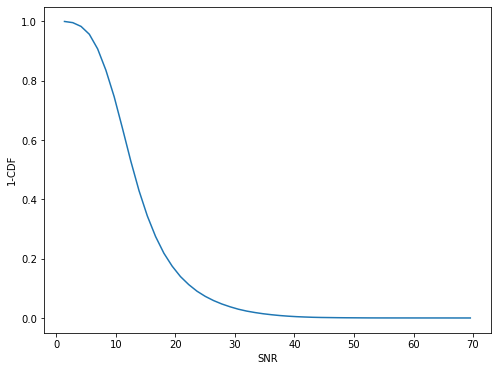

In [19]:
# ploto SNR histogram

hist, bin_edges = np.histogram(gs.snMedian, bins=50)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
pdf = hist/hist.sum()
cdf = np.cumsum(pdf)

from matplotlib.widgets import Cursor
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bin_centers, 1-cdf)
ax.set_ylabel('1-CDF')
ax.set_xlabel('SNR')

In [20]:
print('Estimated dataset size: %.1fGB' % (len(gs)*len(wl_grid)*4/1024/1024/1024))

Estimated dataset size: 2.9GB


In [21]:
# create a wrapper that returns the index also
from pre_processing import download_spectrum
def download_spectrum_wrapper(i):
    spec, _, ivar = download_spectrum(gs.iloc[i], pre_proc=True, wl_grid=wl_grid)
    return i, spec, ivar

In [22]:
# create jobs to download and preprocess
from joblib import Parallel, delayed
res = Parallel(n_jobs=-1, verbose=5, prefer="threads")(delayed(download_spectrum_wrapper)(i) for i in range(len(gs)))

# fiter the good results only (exception encountered during download will return empty arrays)
res = sorted(res, key=lambda x: x[0])
goodRes = [len(val[1]) > 0 for val in res]
gs = gs[goodRes]
gs.index = range(len(gs))
from itertools import compress
res = list(compress(res, goodRes))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4544 tasks    

In [23]:
# save the dataframe
to_s3_pkl(gs, s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs.pkl'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V1/gs.pkl


True

In [24]:
# save the spectra
spec = np.stack([x[1].astype(np.float32) for x in res], axis=0)
assert len([i for i in range(spec.shape[0]) if np.any(np.isnan(spec[i]))])==0, 'NaN found in dataset' # making sure no NaNs
to_s3_npy(spec, s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'spec.npy'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V1/spec.npy


True

In [25]:
# save the ivar
ivar = np.stack([x[2].astype(np.float32) for x in res], axis=0)
to_s3_npy(ivar, s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'ivar.npy'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V1/ivar.npy


True

In [26]:
gs.dtypes

specobjid          object
snMedian          float64
run2d              object
ra                float64
dec               float64
plate               int64
mjd                 int64
fiberid             int64
waveMin           float64
waveMax           float64
z                 float64
waveMin_rest      float64
waveMax_rest      float64
wave_span         float64
weirdness         float64
spectrotype        object
subclass           object
oii_3726_eqw      float64
oii_3729_eqw      float64
neiii_3869_eqw    float64
h_delta_eqw       float64
h_gamma_eqw       float64
oiii_4363_eqw     float64
h_beta_eqw        float64
oiii_4959_eqw     float64
oiii_5007_eqw     float64
hei_5876_eqw      float64
oi_6300_eqw       float64
nii_6548_eqw      float64
h_alpha_eqw       float64
nii_6584_eqw      float64
sii_6717_eqw      float64
sii_6731_eqw      float64
ariii7135_eqw     float64
dtype: object

In [27]:
gs = gs.sort_values(by='snMedian', ascending=False)
gs.index = range(len(gs))

In [28]:
min_snr = gs.iloc[9999].snMedian

Text(0.5, 0, 'index')

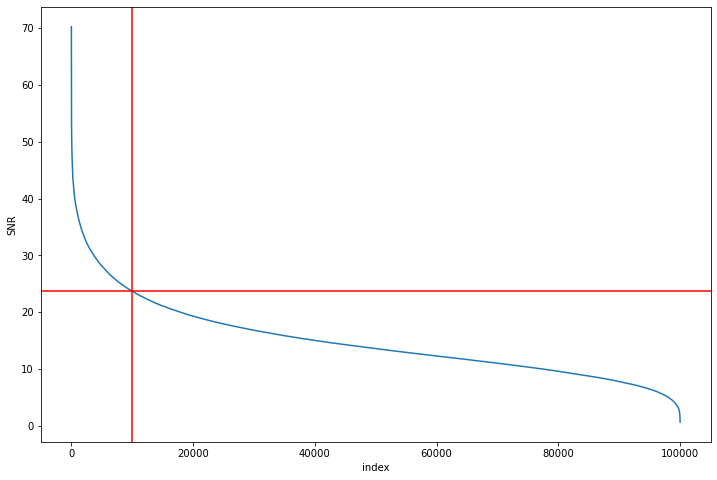

In [29]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(gs.snMedian)
ax.axvline(x=10000, color='red')
ax.axhline(y=min_snr, color='red')
ax.set_ylabel('SNR')
ax.set_xlabel('index')


In [30]:
SNR_th = 20
gs_train = gs[gs.snMedian>SNR_th].sample(10000, random_state=seed)

In [35]:
gs_remain = gs[~gs['specobjid'].isin(gs_train['specobjid'])]

In [36]:
assert len(gs_train)+len(gs_remain)==len(gs)

In [38]:
gs_test = gs_remain.sample(10000, random_state=seed)

In [39]:
to_s3_pkl(gs_train, s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs_train.pkl'))
to_s3_pkl(gs_test, s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs_test.pkl'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V1/gs_train.pkl
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V1/gs_test.pkl


True